# Análisis de Red de Transporte Aéreo

In [1]:
#Paqueterías
using DelimitedFiles
using StatsBase
using LightGraphs
using Distributions
using GLM
using DataFrames
using Plots, LaTeXStrings
pyplot()

┌ Info: Recompiling stale cache file /Users/yuriko/.julia/compiled/v1.1/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1184
┌ Warning: Package Distributions does not have Test in its dependencies:
│ - If you have Distributions checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Distributions
└ Loading Test into Distributions from project dependency, future warnings for Distributions are suppressed.
┌ Info: Recompiling stale cache file /Users/yuriko/.julia/compiled/v1.1/GLM/6OREG.ji for GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1184


Plots.PyPlotBackend()

### Se crea tabla de información con nodos y enlaces

In [2]:
#SE IMPORTA LA LISTA DE REDES, 521 AEROLÍNEAS, 3 ALIANZAS Y 1 GLOBAL
info_aerolineas = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/aerolineas_matrices/nueva_lista_aerolineas.csv", ',', String);
lista_aerolineas = info_aerolineas[:, 2]

526-element Array{String,1}:
 "Airlines"     
 "global"       
 "Star_Alliance"
 "Sky_Team"     
 "oneworld"     
 "AA"           
 "TK"           
 "DL"           
 "MU"           
 "CZ"           
 "UA"           
 "FR"           
 "BA"           
 ⋮              
 "H7"           
 "GY"           
 "EW"           
 "D6"           
 "7E"           
 "6Y"           
 "6I"           
 "5M"           
 "5G"           
 "4K"           
 "4D"           
 "4B"           

In [3]:
#NOMBRE DE LA AEROLÍNEA (ARCHIVO) ciclo for para todas las aerolíneas

tabla_info_net = ["Airline" "Nodes" "Links" "Density" "Av. Degree" "Av. Betweenness" " Global Clustering Coefficient" "Coverage" "Normalización"]

for i in 2:length(lista_aerolineas) #Desde el 2 para no tomar la primera entrada "Airlines"
    
    airline_code = lista_aerolineas[i] #Código
    aerolinea_matriz = string(airline_code, "_import_matrix.csv")
    leo_matriz = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/RESULTADOS_SCRIPT/YURIKO_TESIS/$airline_code/matriz/$aerolinea_matriz", Int64)
    
    nodos = size(leo_matriz)[1]
    enlaces = counts(leo_matriz)[2]
    
    denom = nodos * (nodos - 1)
    densidad = enlaces / denom
    
    aerolinea_in_degree = string(airline_code, "_in_degree.csv")
    #leo_in_degree = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/RESULTADOS_SCRIPT/YURIKO_TESIS/$airline_code/grados/$aerolinea_in_degree", Float64)
    promedio_degree = enlaces/nodos
    #datos_in_degree = push!(datos_in_degree, promedio_degree)
    
    grafo = DiGraph(leo_matriz)
    
    res = betweenness_centrality(grafo, endpoints=true)
    av_bet = mean(res)
    
    gcc = global_clustering_coefficient(grafo)

    aerolinea_cobertura = string(airline_code, "_layer_coverage.csv")
    leo_cobertura = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/RESULTADOS_SCRIPT/YURIKO_TESIS/$airline_code/cobertura2/$aerolinea_cobertura", Float64)
    #coberturas = push!(coberturas, leo_cobertura[1])

    normalizacion = leo_cobertura / nodos
    
    renglon = [airline_code nodos enlaces densidad promedio_degree av_bet gcc leo_cobertura[1] normalizacion]
    tabla_info_net = vcat(tabla_info_net, renglon)
    
end

return tabla_info_net 

526×9 Array{Any,2}:
 "Airline"            "Nodes"  …     "Coverage"   "Normalización"
 "global"         3072            543.748        0.177001        
 "Star_Alliance"   934            384.347        0.411507        
 "Sky_Team"        900            288.584        0.320648        
 "oneworld"        698            141.492        0.202711        
 "AA"              259         …   57.159        0.220691        
 "TK"              242            232.862        0.96224         
 "DL"              230             67.1714       0.29205         
 "MU"              192            180.858        0.941967        
 "CZ"              188            126.27         0.671648        
 "UA"              184         …  120.547        0.655149        
 "FR"              176            164.743        0.936038        
 "BA"              175            174.089        0.994793        
 ⋮                             ⋱                                 
 "H7"                2              2.0          1.0    

# Función para encontrar la regresión lineal

In [4]:
function regresion_lineal_norm(N::String, V::String)
    
    if N == "Global y Alianzas"
        k1 = 2
        k2 = 5
        
        elseif N == "Alianzas"
            k1 = 3
            k2 = 5
            
            elseif N == "Alianzas y Aerolíneas"
                k1 = 3
                k2 = length(lista_aerolineas)
   
                
                elseif N == "Aerolíneas"
                    k1 = 6
                    k2 = length(lista_aerolineas)
        
                    elseif N == "Todo"
                    k1 = 2
                    k2 = length(lista_aerolineas)
                
    end
    
    if V == "Nodes"
        c = 2
        t = Int64
        
        elseif V == "Links"
            c = 3
            t = Int64
            
            elseif V == "Density"
                c = 4
                t = Float64
                
                elseif V == "Av. Degree"
                    c = 5
                    t = Float64
                    
                    elseif V == "Av. Betweenness"
                        c = 6
                        t = Float64
                        
                        elseif V == "Global Clustering Coefficient"
                            c = 7
                            t = Float64
                            
                       
    end
    
    columna_x = tabla_info_net[:, c] #columna propiedad buscada (x)
    x = columna_x[k1:k2]
    x = convert(Array{t,1}, x)
    
    columna_y = tabla_info_net[:, 9] #columna cobertura normalizada (y)
    y = columna_y[k1:k2]
    y = convert(Array{Float64,1}, y)
    

    
    df_cov = hcat(x, y)
    df_cov = convert(DataFrame, df_cov)
    
    cov = lm(@formula(x2 ~ x1), df_cov)
    
    return cov
    
end

regresion_lineal_norm (generic function with 1 method)

In [5]:
function regresion_lineal_cob(N::String, V::String)
    
    if N == "Global y Alianzas"
        k1 = 2
        k2 = 5
        
        elseif N == "Alianzas"
            k1 = 3
            k2 = 5
            
            elseif N == "Alianzas y Aerolíneas"
                k1 = 3
                k2 = length(lista_aerolineas)
   
                
                elseif N == "Aerolíneas"
                    k1 = 6
                    k2 = length(lista_aerolineas)
        
                    elseif N == "Todo"
                    k1 = 2
                    k2 = length(lista_aerolineas)
                
    end
    
    if V == "Nodes"
        c = 2
        t = Int64
        
        elseif V == "Links"
            c = 3
            t = Int64
            
            elseif V == "Density"
                c = 4
                t = Float64
                
                elseif V == "Av. Degree"
                    c = 5
                    t = Float64
                    
                    elseif V == "Av. Betweenness"
                        c = 6
                        t = Float64
                        
                        elseif V == "Global Clustering Coefficient"
                            c = 7
                            t = Float64
                            
                       
    end
    
    columna_x = tabla_info_net[:, c] #columna propiedad buscada (x)
    x = columna_x[k1:k2]
    x = convert(Array{t,1}, x)
    
    columna_y = tabla_info_net[:, 8] #columna cobertura (y)
    y = columna_y[k1:k2]
    y = convert(Array{Float64,1}, y)
    
    #y_cobertura = Array{Float64}(undef, 0)
    
    df_cov = hcat(x, y)
    df_cov = convert(DataFrame, df_cov)
    
    cov = lm(@formula(x2 ~ x1), df_cov)
    
    return cov
    
end

regresion_lineal_cob (generic function with 1 method)

In [6]:
#Datos
tabla_info_net

526×9 Array{Any,2}:
 "Airline"            "Nodes"  …     "Coverage"   "Normalización"
 "global"         3072            543.748        0.177001        
 "Star_Alliance"   934            384.347        0.411507        
 "Sky_Team"        900            288.584        0.320648        
 "oneworld"        698            141.492        0.202711        
 "AA"              259         …   57.159        0.220691        
 "TK"              242            232.862        0.96224         
 "DL"              230             67.1714       0.29205         
 "MU"              192            180.858        0.941967        
 "CZ"              188            126.27         0.671648        
 "UA"              184         …  120.547        0.655149        
 "FR"              176            164.743        0.936038        
 "BA"              175            174.089        0.994793        
 ⋮                             ⋱                                 
 "H7"                2              2.0          1.0    

In [7]:
#Densidad
density = tabla_info_net[:,4]

526-element Array{Any,1}:
  "Density"           
 0.003507802324161511 
 0.007519892772961894 
 0.007266098133728835 
 0.0073565382544100175
 0.01893089102391428  
 0.00925894173725181  
 0.021758116574900323 
 0.028632198952879582 
 0.03527136192968483  
 0.026876930387265383 
 0.08064935064935065  
 0.012216748768472906 
 ⋮                    
 1.0                  
 1.0                  
 0.5                  
 1.0                  
 1.0                  
 1.0                  
 1.0                  
 1.0                  
 1.0                  
 1.0                  
 1.0                  
 1.0                  

In [8]:
#Cobertura
coverage = tabla_info_net[:,8]

526-element Array{Any,1}:
    "Coverage"     
 543.7477376302082 
 384.3474197002141 
 288.5836444444444 
 141.49216332378222
  57.15899613899614
 232.8619834710744 
  67.1714347826087 
 180.85765625      
 126.26984042553191
 120.54739130434781
 164.74267045454545
 174.08885714285708
   ⋮               
   2.0             
   2.0             
   1.5             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             

In [9]:
#Variables Densidad y Cobertura

densidad = density[2:end]

cobertura = coverage[2:end]



525-element Array{Any,1}:
 543.7477376302082 
 384.3474197002141 
 288.5836444444444 
 141.49216332378222
  57.15899613899614
 232.8619834710744 
  67.1714347826087 
 180.85765625      
 126.26984042553191
 120.54739130434781
 164.74267045454545
 174.08885714285708
 113.85226744186045
   ⋮               
   2.0             
   2.0             
   1.5             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             

In [25]:
densidad_g = densidad[1]
densidad_al = densidad[2:4]
densidad_aer = densidad[5:end]

cobertura_g = cobertura[1]
cobertura_al = cobertura[2:4]
cobertura_aer = cobertura[5:end]

0.003507802324161511

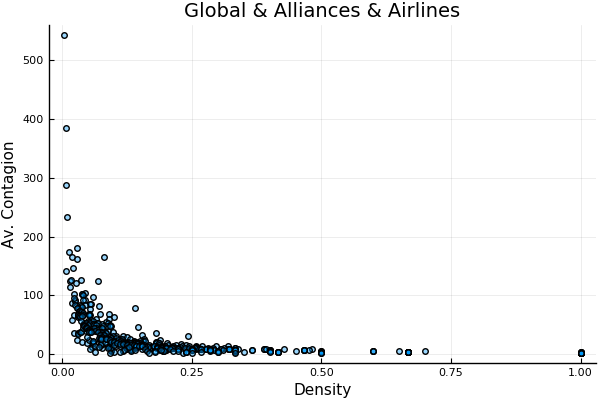

In [15]:
# Grafico densidad vs cobertura

plot_densidad_cobertura = scatter(densidad, cobertura,
                                    title = "Global & Alliances & Airlines",
                                    xlabel = "Density",
                                    ylabel = "Av. Contagion",
                                    legend = false,
                                    #size = (500,500),
                                    #aspect_ratio= 1,
                                    alpha = 0.4)

In [27]:
#scatter(densidad_g, cobertura_g)
[densidad_g]

1-element Array{Float64,1}:
 0.003507802324161511

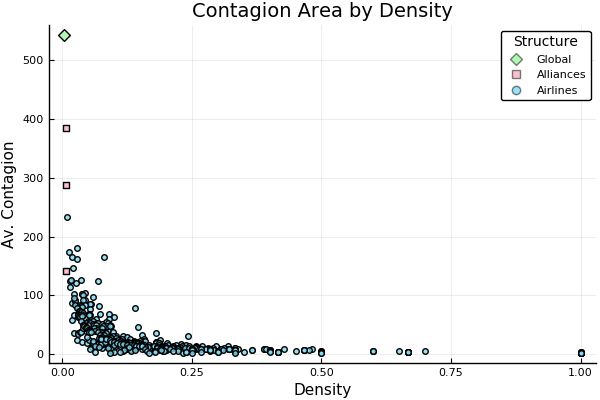

In [83]:
# Grafico densidad vs cobertura dividido

plot_densidad_cobertura = scatter([densidad_g], [cobertura_g],
                                    title = "Contagion Area by Density",
                                    xlabel = "Density",
                                    ylabel = "Av. Contagion",
                                    legend = true,
                                    legendtitle = "Structure",
                                    label = "Global",
                                    #size = (500,500),
                                    #aspect_ratio= 1,
                                    markershape = :diamond,
                                    markersize = 6,
                                    #markeralpha = 0.6,
                                    markercolor = "#A9F5A9",
                                    markerstrokealpha = 0.5,
                                    alpha = 0.9)
scatter!(densidad_al, cobertura_al,
            legend = true,
            label = "Alliances",
            markershape = :square,
            markersize = 5,
            markeralpha = 0.7,#,
            markerstrokealpha = 0.5,
            markercolor = "#F5A9BC")
scatter!(densidad_aer, cobertura_aer,
            legend = true,
            label = "Airlines",
            markershape = :circle,
            markersize = 4,
            markercolor = "#81DAF5",
            markerstrokealpha = 0.5,
            markeralpha = 0.8)

In [110]:
savefig(plot_densidad_cobertura, "/Users/yuriko/Desktop/plot_densidad_cobertura.pdf")

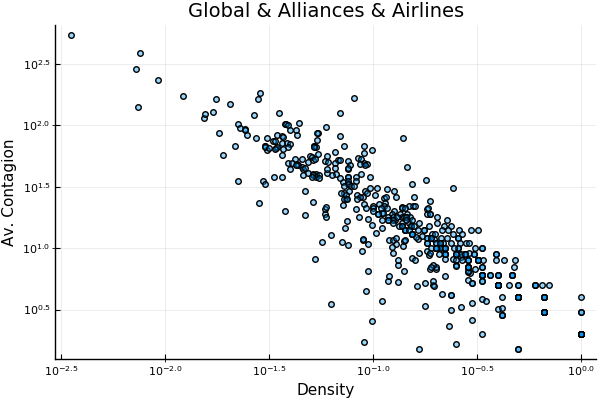

In [66]:
# Grafico en escala log-log
plot_densidad_cobertura_log = scatter(densidad, cobertura,
                                        xscale =(:log10),
                                        yscale =(:log10),
                                        title = "Global & Alliances & Airlines",
                                        xlabel = "Density",
                                        ylabel = "Av. Contagion",
                                        legend = false,
                                        #size = (500,500),
                                        #aspect_ratio= 1,
                                        alpha = 0.4)

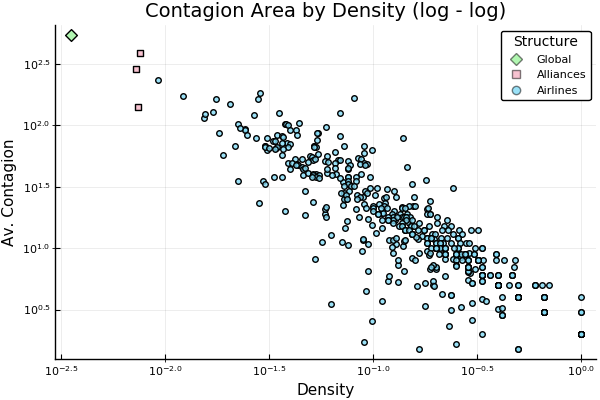

In [84]:
plot_densidad_cobertura_log = scatter([densidad_g], [cobertura_g],
                                    title = "Contagion Area by Density (log - log)",
                                    xlabel = "Density",
                                    ylabel = "Av. Contagion",
                                    xscale =(:log10),
                                    yscale =(:log10),
                                    legend = true,
                                    legendtitle = "Structure",
                                    label = "Global",
                                    #size = (500,500),
                                    #aspect_ratio= 1,
                                    markershape = :diamond,
                                    markersize = 6,
                                    #markeralpha = 0.6,
                                    markercolor = "#A9F5A9",
                                    markerstrokealpha = 0.5,
                                    alpha = 0.9)
scatter!(densidad_al, cobertura_al,
            legend = true,
            label = "Alliances",
            markershape = :square,
            markersize = 5,
            markeralpha = 0.7,#,
            markerstrokealpha = 0.5,
            markercolor = "#F5A9BC")
scatter!(densidad_aer, cobertura_aer,
            legend = true,
            label = "Airlines",
            markershape = :circle,
            markersize = 4,
            markercolor = "#81DAF5",
            markerstrokealpha = 0.5,
            markeralpha = 0.8)

In [85]:
# Hago una tabla densidad, cobertura

df_densidad_cobertura = hcat(densidad, cobertura)
df_densidad_cobertura = convert(DataFrame, df_densidad_cobertura)

,x1,x2
,Float64,Float64
1,0.0035078,543.748
2,0.00751989,384.347
3,0.0072661,288.584
4,0.00735654,141.492
5,0.0189309,57.159
6,0.00925894,232.862
7,0.0217581,67.1714
8,0.0286322,180.858
9,0.0352714,126.27


In [86]:
#Obtengo log_densidad
log_densidad = log.(df_densidad_cobertura.x1)

525-element Array{Float64,1}:
 -5.652765556070894 
 -4.89020340003669  
 -4.924535839393676 
 -4.912165802756871 
 -3.9669602454595347
 -4.682165520089021 
 -3.8277684152027502
 -3.5532233569228424
 -3.3446839210854535
 -3.6164869667504806
 -2.5176445259082962
 -4.4049474188648965
 -4.175475853483881 
  ⋮                 
  0.0               
  0.0               
 -0.6931471805599453
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               

In [87]:
#Obtengo log_cobertura
log_cobertura = log.(df_densidad_cobertura.x2)

525-element Array{Float64,1}:
 6.298485421714162 
 5.951546882360908 
 5.664984972677177 
 4.9522443326788075
 4.04583679060857  
 5.450445932442019 
 4.207248079518242 
 5.197710292309866 
 4.8384212076938065
 4.79204296444569  
 5.104384683497936 
 5.159565842100139 
 4.734901708357632 
 ⋮                 
 0.6931471805599453
 0.6931471805599453
 0.4054651081081644
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453

In [88]:
#Lo convierto en un data frame

df_densidad_cobertura_log = hcat(log_densidad, log_cobertura)
df_densidad_cobertura_log = convert(DataFrame, df_densidad_cobertura_log)

,x1,x2
,Float64,Float64
1,-5.65277,6.29849
2,-4.8902,5.95155
3,-4.92454,5.66498
4,-4.91217,4.95224
5,-3.96696,4.04584
6,-4.68217,5.45045
7,-3.82777,4.20725
8,-3.55322,5.19771
9,-3.34468,4.83842


In [89]:
#Ajustamos una recta x2 = log(cobertura) y x1=log(densidad)
ajuste_log_densidad_cobertura = lm(@formula(x2 ~ x1), df_densidad_cobertura_log)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: x2 ~ 1 + x1

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)  0.746592 0.0453988  16.4452   <1e-48
x1           -1.00427 0.0212059 -47.3578   <1e-99


In [90]:
coeficientes_dc = round.(coef(ajuste_log_densidad_cobertura), digits=5)

2-element Array{Float64,1}:
  0.74659
 -1.00427

In [96]:
r_2 = round.(r2(ajuste_log_densidad_cobertura), digits=5)

0.8109

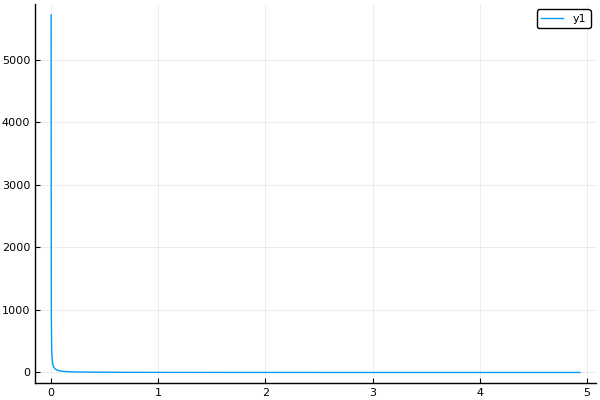

In [91]:
my_equation(x) = exp(coeficientes_dc[2]*log(x) + coeficientes_dc[1])
plot(my_equation)

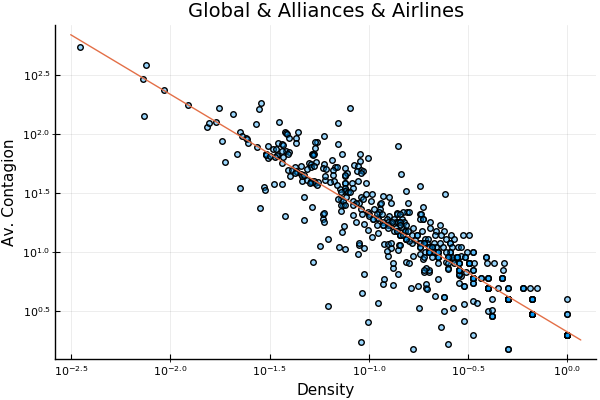

In [93]:
# Grafico en escala log-log con ajuste
plot_densidad_cobertura_log = scatter(densidad, cobertura,
                                        xscale =(:log10),
                                        yscale =(:log10),
                                        title = "Global & Alliances & Airlines",
                                        xlabel = "Density",
                                        ylabel = "Av. Contagion",
                                        legend = false,
                                        #size = (500,500),
                                        #aspect_ratio= 1,
                                        alpha = 0.4)
plot!(my_equation)

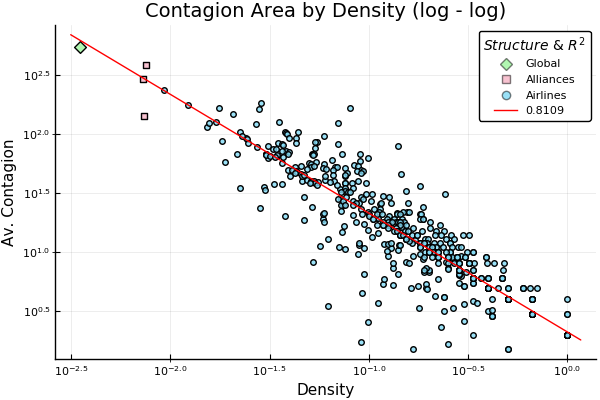

In [109]:
# Grafico en escala log-log con ajuste

plot_densidad_cobertura_log = scatter([densidad_g], [cobertura_g],
                                    title = "Contagion Area by Density (log - log)",
                                    xlabel = "Density",
                                    ylabel = "Av. Contagion",
                                    xscale =(:log10),
                                    yscale =(:log10),
                                    legend = true,
                                    legendtitle = L"Structure\ &\ R^2",
                                    label = "Global",
                                    #size = (500,500),
                                    #aspect_ratio= 1,
                                    markershape = :diamond,
                                    markersize = 6,
                                    #markeralpha = 0.6,
                                    markercolor = "#A9F5A9",
                                    markerstrokealpha = 0.5,
                                    alpha = 0.9)
scatter!(densidad_al, cobertura_al,
            legend = true,
            label = "Alliances",
            markershape = :square,
            markersize = 5,
            markeralpha = 0.7,#,
            markerstrokealpha = 0.5,
            markercolor = "#F5A9BC")
scatter!(densidad_aer, cobertura_aer,
            legend = true,
            label = "Airlines",
            markershape = :circle,
            markersize = 4,
            markercolor = "#81DAF5",
            markerstrokealpha = 0.5,
            markeralpha = 0.8)
plot!(my_equation,
        legend = true,
        label = "$r_2",
        linecolor = :red)

In [111]:
savefig(plot_densidad_cobertura_log, "/Users/yuriko/Desktop/plot_densidad_cobertura_log.pdf")

### Gráfica de cobertura (Densidad vs. Cobertura. Alianzas & Aerolíneas)

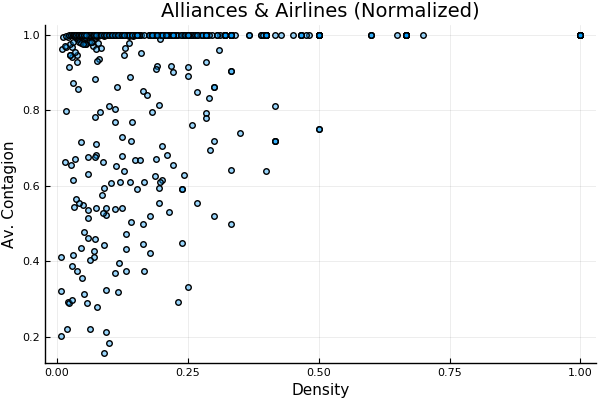

In [15]:
# Densidad vs. Cobertura Normalizada. Alianzas & Aerolíneas

w = tabla_info_net[:, 4] #Densidad
c = tabla_info_net[:, 9] #Coberturas normalizada

x = Array{Float64}(undef, 0)
y = Array{Float64}(undef, 0)
for i in 3:length(lista_aerolineas)
    x = push!(x, w[i])
    y = push!(y, c[i])
end

equation(x) = coef_r[2]*x + coef_r[1]

density_normalizada = scatter(x, y,
    #color = "#0f87bf",
    title = "Alliances & Airlines (Normalized)",
    xlabel = "Density",
    ylabel = "Av. Contagion",
    legend = false,
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
#plot!(equation, 0:0.01:1.1, 
 #   legend = true,
  #  label = "$r_2")



In [29]:
savefig(density_normalizada, "/Users/yuriko/Desktop/density_normalizada.pdf")

In [16]:
reg_no_norm = regresion_lineal_cob("Alianzas y Aerolíneas", "Density")

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: x2 ~ 1 + x1

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)   43.1242    2.0289  21.2549   <1e-71
x1           -69.3852   5.95214 -11.6572   <1e-27


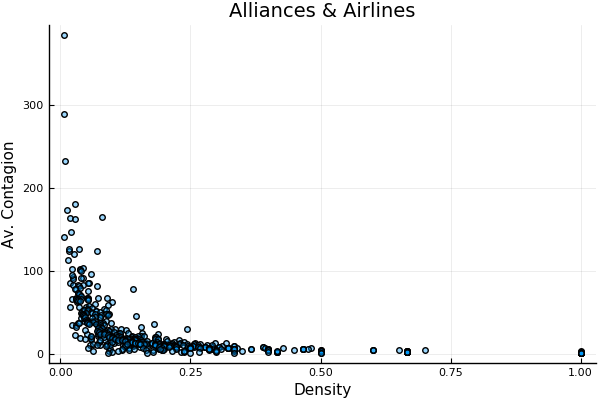

In [17]:
# Densidad vs. Cobertura No Normalizada. Alianzas & Aerolíneas

w = tabla_info_net[:, 4] #Densidad
c = tabla_info_net[:, 8] #Coberturas

x = Array{Float64}(undef, 0)
y = Array{Float64}(undef, 0)
for i in 3:length(lista_aerolineas)
    x = push!(x, w[i])
    y = push!(y, c[i])
end
#@show x[1:5]
#@show y[1:5]
density_no_norm = scatter(x, y,
    #color = "#0f87bf",
    title = "Alliances & Airlines",
    xlabel = "Density",
    ylabel = "Av. Contagion",
    legend = false,
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
#plot!(equation, 0:0.01:1.1, 
#    legend = true)



In [18]:
#Densidad 
x

524-element Array{Float64,1}:
 0.007519892772961894 
 0.007266098133728835 
 0.0073565382544100175
 0.01893089102391428  
 0.00925894173725181  
 0.021758116574900323 
 0.028632198952879582 
 0.03527136192968483  
 0.026876930387265383 
 0.08064935064935065  
 0.012216748768472906 
 0.015367877056983545 
 0.01764705882352941  
 ⋮                    
 1.0                  
 1.0                  
 0.5                  
 1.0                  
 1.0                  
 1.0                  
 1.0                  
 1.0                  
 1.0                  
 1.0                  
 1.0                  
 1.0                  

In [9]:
savefig(density_no_norm, "/Users/yuriko/Desktop/density_no_norm.pdf")

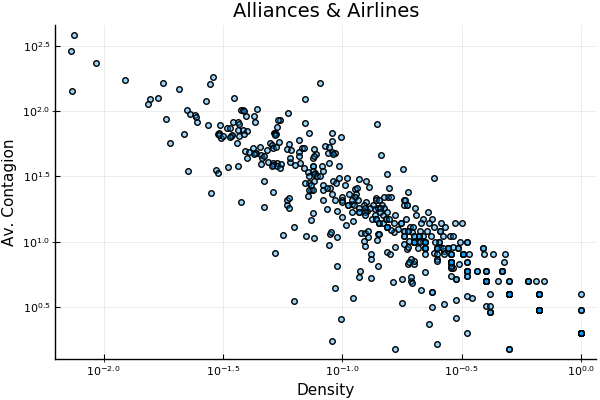

In [10]:
# Densidad vs. Cobertura No Normalizada. Alianzas & Aerolíneas


density_log_log = scatter(x, y,
    title = "Alliances & Airlines",
    xlabel = "Density",
    ylabel = "Av. Contagion",
    legend = false,
    xscale=(:log10),
    yscale=(:log10),
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
#plot!(equation, -5:0.01:1.1, 
#    legend = true)

In [11]:
savefig(density_log_log, "/Users/yuriko/Desktop/density_log_log.pdf")

x[1:5] = [-4.8902, -4.92454, -4.91217, -3.96696, -4.68217]
y[1:5] = [5.95155, 5.66498, 4.95224, 4.04584, 5.45045]


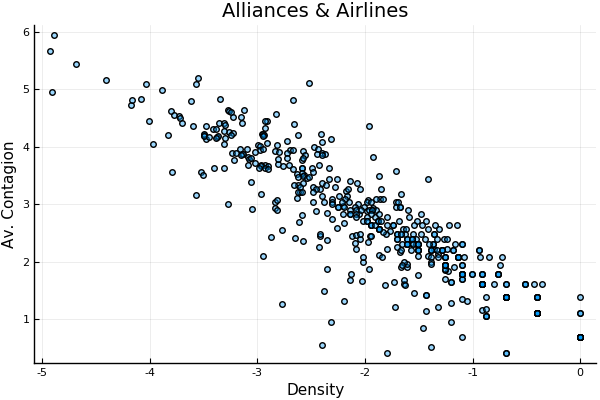

In [11]:
# Densidad vs. Cobertura No Normalizada. Alianzas & Aerolíneas

w = tabla_info_net[:, 4] #Densidad
c = tabla_info_net[:, 8] #Coberturas

x = Array{Float64}(undef, 0)
y = Array{Float64}(undef, 0)
for i in 3:length(lista_aerolineas)
    x = push!(x, log(w[i]))
    y = push!(y, log(c[i]))
end
@show x[1:5]
@show y[1:5]
#equation(x) = -1.00804*x + 0.740709 #?

plot_densidad_aa = scatter(x, y,
    #color = "#0f87bf",
    title = "Alliances & Airlines",
    xlabel = "Density",
    ylabel = "Av. Contagion",
    legend = false,
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
#plot!(equation, -5:0.01:1.1, 
 #   legend = true)

In [12]:
#log recta

    df_cov = hcat(x, y)
    df_cov = convert(DataFrame, df_cov)
    
    cov = lm(@formula(x2 ~ x1), df_cov)
    

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: x2 ~ 1 + x1

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)  0.745155 0.0457838  16.2755   <1e-47
x1           -1.00516 0.0215087 -46.7327   <1e-99


In [13]:
r_2 = round.(r2(cov), digits=5) #r^2

0.80709

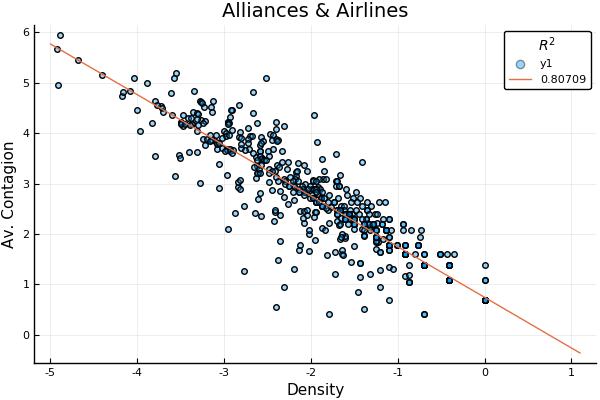

In [14]:

w = tabla_info_net[:, 4] #Densidad
c = tabla_info_net[:, 8] #Coberturas

x = Array{Float64}(undef, 0)
y = Array{Float64}(undef, 0)
for i in 3:length(lista_aerolineas)
    x = push!(x, log(w[i]))
    y = push!(y, log(c[i]))
end
#@show x[1:5]
#@show y[1:5]
equation(x) = -1.00516*x + 0.745155 #?

density_log_recta = scatter(x, y,
    #color = "#0f87bf",
    title = "Alliances & Airlines",
    xlabel = "Density",
    ylabel = "Av. Contagion",
    legend = false,
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
plot!(equation, -5:0.01:1.1,
    legend = true,
    legendtitle = L"R^2",
    label = "$r_2")

In [16]:
savefig(density_log_recta, "/Users/yuriko/Desktop/density_log_recta.pdf")

In [17]:
round.(r2(cov), digits=5) #r^2

0.80709

In [18]:
recta=round.(predict(cov), digits=5)

524-element Array{Float64,1}:
 5.66059
 5.6951 
 5.68267
 4.73259
 5.45148
 4.59268
 4.31671
 4.1071 
 4.3803 
 3.27579
 5.17283
 4.94218
 4.80317
 ⋮      
 0.74516
 0.74516
 1.44188
 0.74516
 0.74516
 0.74516
 0.74516
 0.74516
 0.74516
 0.74516
 0.74516
 0.74516

x[1:5] = [-4.8902, -4.92454, -4.91217, -3.96696, -4.68217]
recta[1:5] = [5.66059, 5.6951, 5.68267, 4.73259, 5.45148]


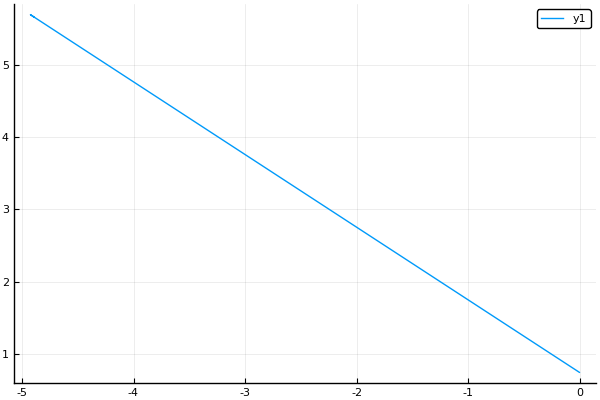

In [19]:
@show x[1:5]
@show recta[1:5]
plot(x,recta)

In [20]:
#Ajuste lineal

    df_cov = hcat(x, y)
    df_cov = convert(DataFrame, df_cov)
    
    cov = lm(@formula(x2 ~ x1), df_cov)
    

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: x2 ~ 1 + x1

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)  0.745155 0.0457838  16.2755   <1e-47
x1           -1.00516 0.0215087 -46.7327   <1e-99


In [21]:
10^-0.2

0.6309573444801932

In [22]:
x

524-element Array{Float64,1}:
 -4.89020340003669  
 -4.924535839393676 
 -4.912165802756871 
 -3.9669602454595347
 -4.682165520089021 
 -3.8277684152027502
 -3.5532233569228424
 -3.3446839210854535
 -3.6164869667504806
 -2.5176445259082962
 -4.4049474188648965
 -4.175475853483881 
 -4.037186148382152 
  ⋮                 
  0.0               
  0.0               
 -0.6931471805599453
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               

x[1:5] = [0.00751989, 0.0072661, 0.00735654, 0.0189309, 0.00925894]
y[1:5] = [384.347, 288.584, 141.492, 57.159, 232.862]


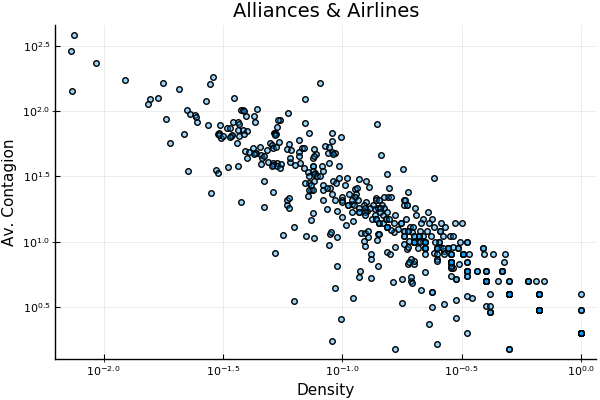

In [23]:
# Densidad vs. Cobertura No Normalizada. Alianzas & Aerolíneas

w = tabla_info_net[:, 4] #Densidad
c = tabla_info_net[:, 8] #Coberturas

x = Array{Float64}(undef, 0)
y = Array{Float64}(undef, 0)
for i in 3:length(lista_aerolineas)
    x = push!(x, w[i])
    y = push!(y, c[i])
end
@show x[1:5]
@show y[1:5]
#equation(x) = -1.00804*x + 0.740709 #?

plot_densidad_aa = scatter(x, y,
    #color = "#0f87bf",
    title = "Alliances & Airlines",
    xlabel = "Density",
    ylabel = "Av. Contagion",
    legend = false,
    xscale=(:log10),
    yscale=(:log10),
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
#plot!(equation, -5:0.01:1.1, 
#    legend = true)

In [24]:
recta

524-element Array{Float64,1}:
 5.66059
 5.6951 
 5.68267
 4.73259
 5.45148
 4.59268
 4.31671
 4.1071 
 4.3803 
 3.27579
 5.17283
 4.94218
 4.80317
 ⋮      
 0.74516
 0.74516
 1.44188
 0.74516
 0.74516
 0.74516
 0.74516
 0.74516
 0.74516
 0.74516
 0.74516
 0.74516

In [25]:
antilog = []
for i in 1:length(recta)
    anti = exp10(recta[i])
    antilog = push!(antilog, anti)
end
return antilog

524-element Array{Any,1}:
 457709.57743124996    
 495564.2855622974     
 481581.72720385296    
  54024.405937753756   
 282800.38736574224    
  39145.33373407262    
  20735.284571121538   
  12796.759265077953   
  24004.905465538195   
   1887.078645025263   
 148877.81970949413    
  87534.65008183723    
  63557.9674132916     
      ⋮                
      5.561090976980356
      5.561090976980356
     27.661772167957825
      5.561090976980356
      5.561090976980356
      5.561090976980356
      5.561090976980356
      5.561090976980356
      5.561090976980356
      5.561090976980356
      5.561090976980356
      5.561090976980356

x[1:5] = [0.00751989, 0.0072661, 0.00735654, 0.0189309, 0.00925894]
y[1:5] = [384.347, 288.584, 141.492, 57.159, 232.862]


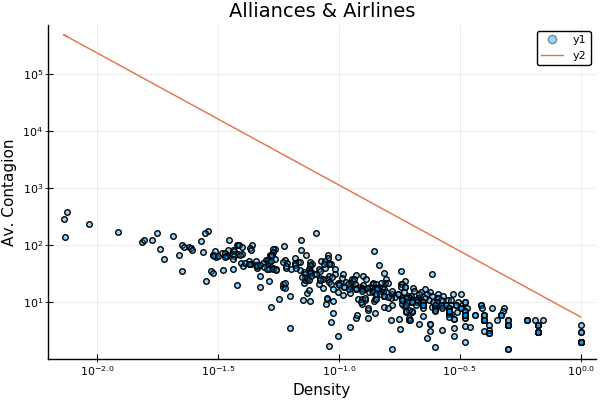

In [26]:
# Densidad vs. Cobertura No Normalizada. Alianzas & Aerolíneas

w = tabla_info_net[:, 4] #Densidad
c = tabla_info_net[:, 8] #Coberturas

x = Array{Float64}(undef, 0)
y = Array{Float64}(undef, 0)
for i in 3:length(lista_aerolineas)
    x = push!(x, w[i])
    y = push!(y, c[i])
end
@show x[1:5]
@show y[1:5]
#equation(x) = -1.00804*x + 0.740709 #?

plot_densidad_aa = scatter(x, y,
    #color = "#0f87bf",
    title = "Alliances & Airlines",
    xlabel = "Density",
    ylabel = "Av. Contagion",
    legend = false,
    xscale=(:log10),
    yscale=(:log10),
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
plot!(x,antilog, 
   legend = true)

In [27]:
recta2=round.(predict(reg_no_norm), digits=6)

524-element Array{Float64,1}:
  42.60246 
  42.620069
  42.613794
  41.810705
  42.481795
  41.614538
  41.137578
  40.676919
  41.259368
  37.528358
  42.276567
  42.057926
  41.899784
   ⋮       
 -26.260964
 -26.260964
   8.431632
 -26.260964
 -26.260964
 -26.260964
 -26.260964
 -26.260964
 -26.260964
 -26.260964
 -26.260964
 -26.260964

x[1:5] = [0.00751989, 0.0072661, 0.00735654, 0.0189309, 0.00925894]
y[1:5] = [384.347, 288.584, 141.492, 57.159, 232.862]


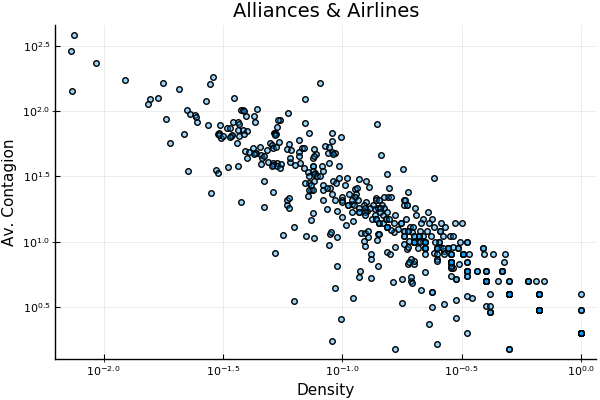

In [28]:
# Densidad vs. Cobertura No Normalizada. Alianzas & Aerolíneas

w = tabla_info_net[:, 4] #Densidad
c = tabla_info_net[:, 8] #Coberturas

x = Array{Float64}(undef, 0)
y = Array{Float64}(undef, 0)
for i in 3:length(lista_aerolineas)
    x = push!(x, w[i])
    y = push!(y, c[i])
end
@show x[1:5]
@show y[1:5]
equation(x) = -1.00804*x + 0.740709 #?

plot_densidad_aa = scatter(x, y,
    #color = "#0f87bf",
    title = "Alliances & Airlines",
    xlabel = "Density",
    ylabel = "Av. Contagion",
    legend = false,
    xscale=(:log10),
    yscale=(:log10),
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
#plot!(equation, 
#   legend = true)